This code creates a heatmap that shows the average time to beaching in a given location

In [204]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [205]:
# dependencies
import pandas as pd
import scipy.interpolate as sci_int
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sci_stats
import cartopy.crs as ccrs
import geopandas as gpd
from numba import jit, int64
import seaborn as sn
import random

#from plotly.offline import init_notebook_mode
#init_notebook_mode(connected=True)

In [3]:
# loading drifter data files
metadata = pd.read_csv('drifter data/global drifter program/csv files/GDP_metadata.csv')
beach_drogued = pd.read_csv('drifter data/global drifter program/csv files/GDP_RunAground_drouged.csv')
beach_undrogued = pd.read_csv('drifter data/global drifter program/csv files/GDP_RunAground_undrouged.csv')
unbeach_drogued= pd.read_csv('GDP_NonRunAground_drouged-004.csv')
unbeach_undrogued = pd.read_csv('GDP_NonRunAground_undrouged-006.csv')

In [206]:
# get lats and lons separated and assign 0 to those that do not beach
beach_drogued_lats = np.array(beach_drogued['lat'])
beach_drogued_longs = np.array(beach_drogued['lon'])

beach_undrogued_lats = np.array(beach_undrogued['lat'])
beach_undrogued_longs = np.array(beach_undrogued['lon'])

unbeach_drogued_lats = np.array(unbeach_drogued['lat'])
unbeach_drogued_longs = np.array(unbeach_drogued['lon'])
unbeach_drogued_values = np.zeros(len(unbeach_drogued))

unbeach_undrogued_lats = np.array(unbeach_undrogued['lat'])
unbeach_undrogued_longs = np.array(unbeach_undrogued['lon'])
unbeach_undrogued_values = np.zeros(len(unbeach_undrogued))

 Now let's visualize the time to beaching. <br> 
 We set time_values = 1 / time_to_beach, then  later set histogram plotting weights = 1 / time_values. This sets '0' never_beached values as 'infinite time.' 

In [207]:
# get the last time values of beached
beach_drogued_last = beach_drogued.drop_duplicates(subset='ID', keep='last') 
beach_undrogued_last = beach_undrogued.drop_duplicates(subset='ID', keep='last')

In [208]:
def find_time_to_beach(beach, beach_last,time_between_register_beaching_and_actually_beaching):
    # DF to Numpy Arrays
    beach_array = beach.to_numpy()
    beach_last_array = beach_last.to_numpy()

    # Create a dictionary to store the last known time for each ID
    last_time_dict = dict(zip(beach_last_array[:, 0], beach_last_array[:, 5]))

    beach_time = []

    # Iterate through beach array and calculate time differences
    for row in beach_array:
        current_ID = row[0]
        last_time = last_time_dict.get(current_ID, None)
        
        if last_time is not None:
            current_time = row[5]
            if current_time != last_time: # prevent 0 value --> infinite time as beach_last exists within beach
                time_difference = last_time - current_time
                beach_time.append(time_difference)
            if current_time == last_time: # keep lat, lon, and values for hist shape the same
                beach_time.append(time_between_register_beaching_and_actually_beaching)

    return beach_time

In [209]:
time_between_register_beaching_and_actually_beaching = 604800 # 1 week to beaching (?)
beach_drogued_time = find_time_to_beach(beach_drogued,beach_drogued_last, time_between_register_beaching_and_actually_beaching)
beach_undrogued_time = find_time_to_beach(beach_undrogued,beach_undrogued_last, time_between_register_beaching_and_actually_beaching)

In [210]:
# set time values as 1 / time
beach_drogued_time_inv = 1 / np.array(beach_drogued_time)
beach_undrogued_time_inv = 1 / np.array(beach_undrogued_time)

In [211]:
# concatenate all together into lats, longs variables for plotting
lats = np.concatenate((beach_drogued_lats, beach_undrogued_lats, unbeach_drogued_lats, unbeach_undrogued_lats))
longs = np.concatenate((beach_drogued_longs, beach_undrogued_longs, unbeach_drogued_longs, unbeach_undrogued_longs))

# concatenate both time to beaching and both unbeach 0 values
values = np.concatenate((beach_drogued_time_inv, beach_undrogued_time_inv, unbeach_drogued_values, unbeach_undrogued_values))
# take the inverse of values in order to set unbeached 0 values to infinity and return time values back to original
values_inv = 1 / values

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


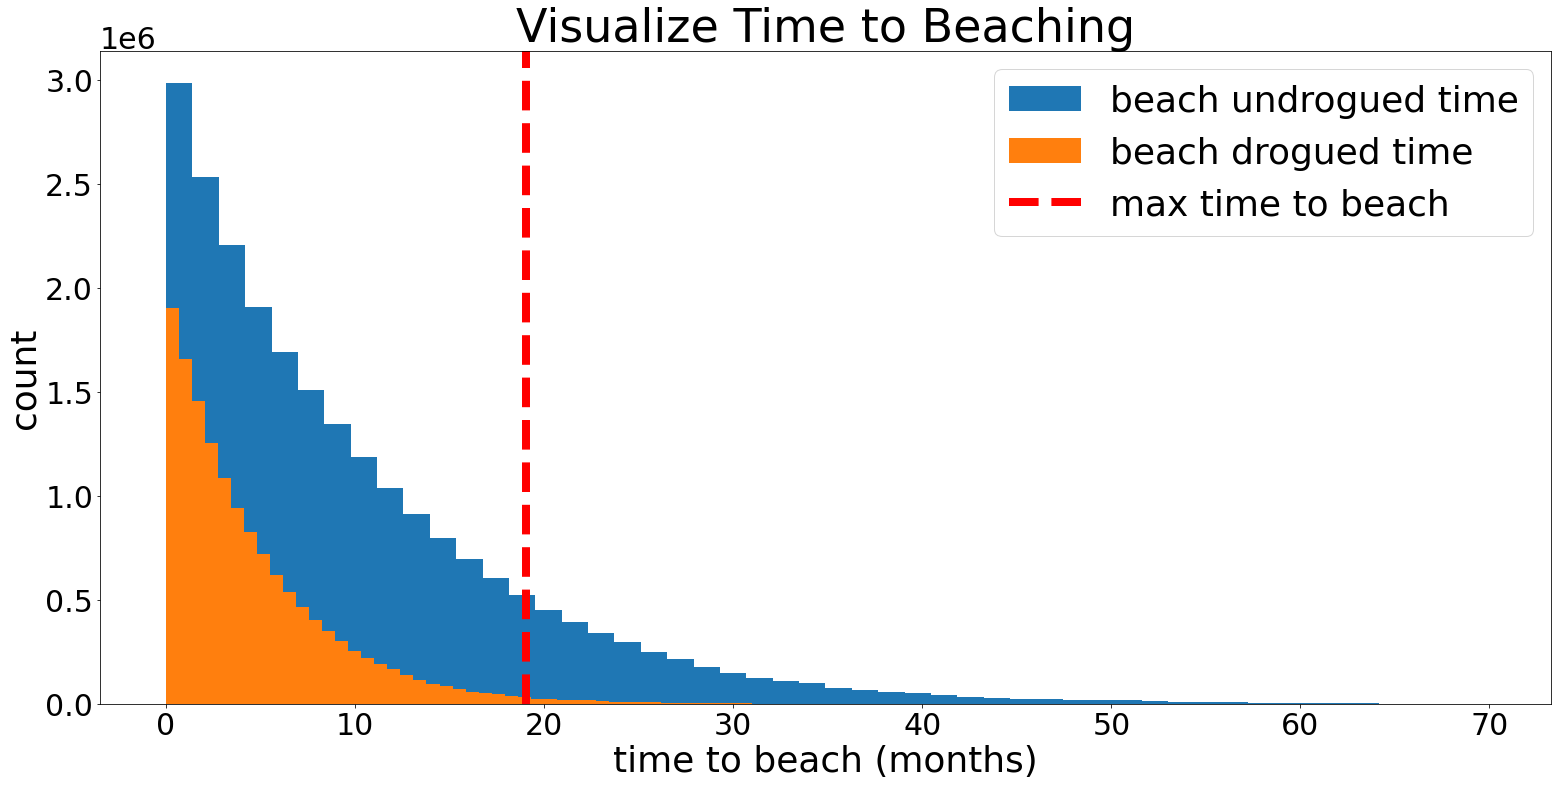

In [212]:
fig = plt.figure(figsize=(26, 12))
plt.hist((1/beach_undrogued_time_inv) / (2.628*10**6), label = 'beach undrogued time',bins = 50)
plt.hist(1/beach_drogued_time_inv / (2.628*10**6), label = 'beach drogued time',bins = 50)
plt.title('Visualize Time to Beaching', fontsize = 46)
plt.xlabel('time to beach (months)',fontsize=36)
plt.ylabel('count', fontsize = 36)
plt.axvline(x=(0.5*10**8) / (2.628*10**6), color='r', linestyle='--', label='max time to beach',linewidth = 8)
plt.legend(fontsize = 36)

In [213]:
# set max time_to_beach i.e, if a value is greater than max or infinity, we set it to the max
max_time_to_beach = 0.5*10**8
values_inv[values_inv == np.inf] = max_time_to_beach
values_inv[values_inv > max_time_to_beach] = max_time_to_beach

In [214]:
# set time scale from seconds to months
values_inv_month = values_inv / (2.628*10**6)

In [215]:
np.shape(values_inv_month)

(165754333,)

In [216]:
print("Shapes:")
print("longs shape:", longs.shape)
print("lats shape:", lats.shape)
print("values_inv_month shape:", values_inv_month.shape)
print("points shape:", points[0].shape, points[1].shape)
print("xi shape:", xi[0].shape, xi[1].shape)

Shapes:
longs shape: (165754333,)
lats shape: (165754333,)
values_inv_month shape: (165754333,)
points shape: (166,) (166,)
xi shape: (166,) (166,)


In [217]:
n_lons, n_lats = 720, 360 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)
statistic, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(longs,lats,values=values_inv_month,bins = [lon_bins,lat_bins])

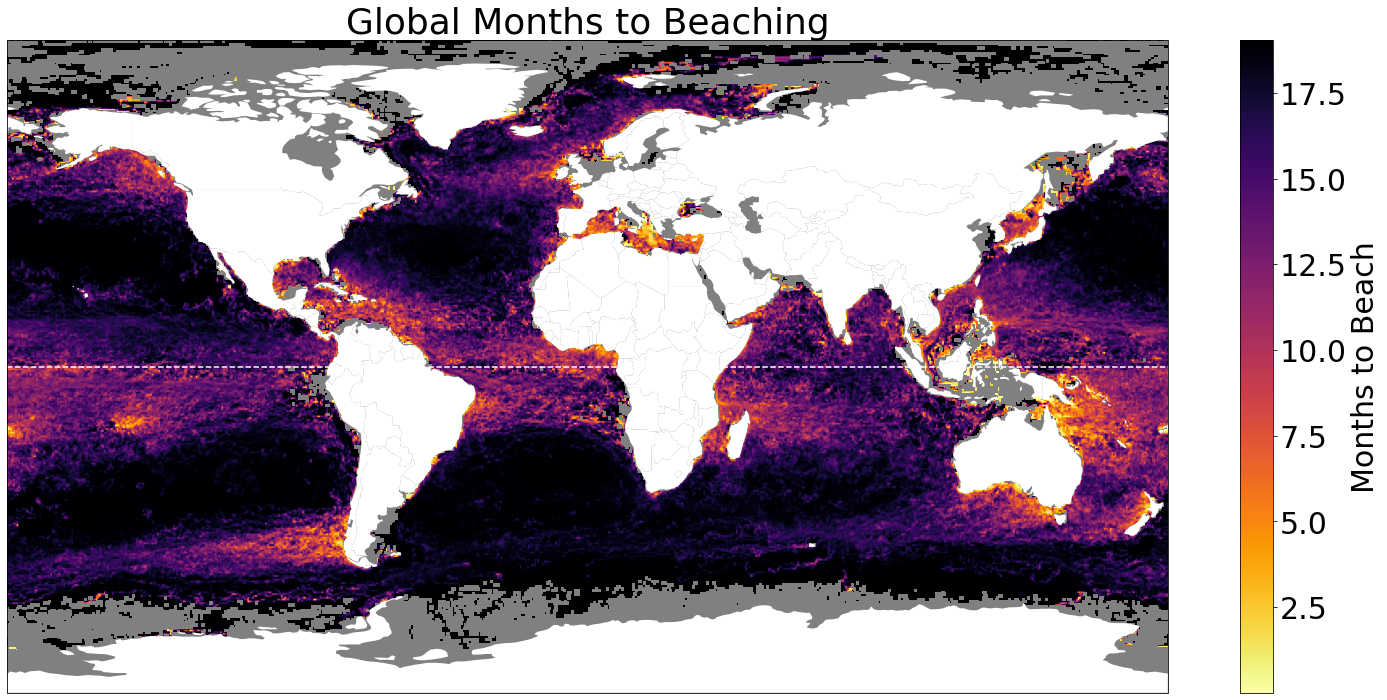

In [218]:
# Given location, time to beaching

fig = plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("inferno_r").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(statistic.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap)

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(label='Months to Beach')
ax.set_aspect('auto')
plt.title('Global Months to Beaching')
plt.axhline(y=0, color='white', linestyle='--', label='Equator')

